In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config('../conf/secret.yaml').data[0]
ts_token = CONF['TUSHARE']['TOKEN']
ts.set_token(ts_token)
pro = ts.pro_api()

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']
# HS300 = list(ts.get_hs300s()['code'])
# HS300_df = pd.read_csv('../database/HS300IDX_ALL.csv')
# HS300 = list(set(HS300_df.con_code))
# HS300 = [x.split('.')[0] for x in HS300]
# ZZ500 = list(ts.get_zz500s()['code'])
# SZ50 = list(ts.get_sz50s()['code'])
# HSALL = list(set(ts.get_stock_basics().index) - set(['601162', '002940', '002939', '300674', '002941']))
# HSALL = HSALL + ['000866', '600001', '000956']

BENCHMARK = '399300'
# BENCHMARK = '163407'  # 兴全300(SZ:163407)
BENCHMARK = '000905'  # 中证500(SH:000905)
# BENCHMARK = '399006'  # 创业板指(SZ:399006)
# BENCHMARK = '159915'  # 创业板指(SZ:399006)
# BENCHMARK = '510300'  # 300ETF(SH:510300)
# BENCHMARK = '512880'  # 证券ETF(SH:512880)
# BENCHMARK = '511220'  # 城投ETF(SH:511220)

TARGET = ['399300']
TARGET = ['000905']
# TARGET = ['399006']
# TARGET = ['510500']
TARGET = ['512500', '161017', '510510', '160119']  # 中证500场内ETF
# TARGET = ['510300', '510330', '160706', '159919', '163407', '159925', '510360']  # 沪深300场内ETF

MONITOR_TARGET = {
    '399300': {'MA': [30, 150], 'ROLLINGMAX': [100], 'ROLLINGMIN': [40], 'NAME': '沪深300指数'},
    '000905': {'MA': [90, 120], 'ROLLINGMAX': [30], 'ROLLINGMIN': [20], 'NAME': '中证500指数'},
#     '163407': {'MA': [30, 90], 'ROLLINGMAX': [130], 'ROLLINGMIN': [40], 'NAME': '兴全300(SZ:163407)'},
#     '510300': {'MA': [30, 90], 'ROLLINGMAX': [130], 'ROLLINGMIN': [40], 'NAME': '300ETF(SH:510300)'},
#     '512000': {'MA': [30, 90], 'ROLLINGMAX': [130], 'ROLLINGMIN': [40], 'NAME': '券商ETF(SH:512000)'},
#     '512500': {'MA': [], 'ROLLINGMAX': [80], 'ROLLINGMIN': [40], 'NAME': '中证500(SH:512500)'},
#     '161017': {'MA': [110, 120], 'ROLLINGMAX': [40], 'ROLLINGMIN': [170], 'NAME': '161017'},
}

ALL_TARGET = TARGET[:]
len(ALL_TARGET)

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

IS_DOWNLOAD_DATA = True

for symbol in TARGET + [BENCHMARK]:
    if not IS_DOWNLOAD_DATA:
        break
        
    print(symbol)

    # 指数
    if symbol in ['399300', '000905', '000016', '399006']:
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # ETF
    else:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        time.sleep(1)
        
#     print(datafile)
    time.sleep(1)

512500
161017
510510
160119
000905
Wall time: 12.2 s


In [3]:
%%time

### 时间设置
start_date = '2008-01-01'
# end_date = '2019-03-01'
end_date = time.strftime('%Y-%m-%d')

POS = 5

### Turtle System
TURTLE_MAX_N = 30
TURTLE_MIN_N = 20

### MA System
MA_MIN_N = 90
MA_MAX_N = 120

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = False
IS_RANDOM_BUY = True
IS_FILTER = False
IS_MARKETUP = False
IS_UNIQUE = False
IS_BUYBENCHMARK = True
IS_SHOWBUYLIST = True
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in TARGET + [BENCHMARK]:
    stock_data_file = '../database/market/%s.csv' % symbol
    try:
        stock_df = pd.read_csv(stock_data_file)
    except:
        print(symbol)
        continue

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
    stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)
    
    # Turtle指标
#     stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
#     stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
#     stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
#     stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
#     stock_df['N'] = stock_df['TR'].rolling(20).mean()
#     stock_df['UNIT'] = (0.01 * START_MONEY) / (stock_df['N'])
    stock_df['ROLLING_%d_MAX' % TURTLE_MAX_N] = stock_df['open'].rolling(TURTLE_MAX_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_MIN_N] = stock_df['open'].rolling(TURTLE_MIN_N).min()
#     stock_df['EWMA'] = stock_df['open'].ewm(alpha=0.1, adjust=False).mean()
    stock_df['MA%d' % MA_MIN_N] = stock_df['open'].rolling(MA_MIN_N).mean()
    stock_df['MA%d' % MA_MAX_N] = stock_df['open'].rolling(MA_MAX_N).mean()
    
    # 减少数据
    stock_df.dropna(how='any', inplace=True)
    
    stock_df_dict[symbol] = stock_df

Wall time: 265 ms


In [5]:
'''抽查数据'''

stock_df_dict[BENCHMARK].head(1)
stock_df_dict[BENCHMARK].tail(1)
# stock_df_dict['512500'].head(2)

df = stock_df_dict[BENCHMARK].iloc[:].copy()
df.columns
df.reset_index(drop=False, inplace=True)
# df = df.astype(dtype={'date': 'datetime64[ns]'})
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index('date', inplace=True)
# ax = df.plot(kind='line', y='close', label='test', linewidth=1, grid=True)
display_charts(df, chart_type='stock', kind='line', 
#                y=['open', 'ROLLING_%d_MAX' % TURTLE_LONG_BUY_N, 'ROLLING_%d_MIN' % TURTLE_LONG_SELL_N, 'MA30', 'MA60', 'MA180'], 
#                y=['open', 'ROLLING_%d_MAX' % TURTLE_LONG_BUY_N, 'ROLLING_%d_MIN' % TURTLE_LONG_SELL_N],
#                y=['open', 'MA10', 'MA30', 'MA60', 'MA90', 'MA180'],
               figsize=(900, 600))

'抽查数据'

,open,close,o_pct_chg,c_o_pct_chg,ROLLING_30_MAX,ROLLING_20_MIN,MA90,MA120
date,,,,,,,,
2007-07-13,3671.46,3655.84,0.003296,0.000076,4539.58,3359.09,3623.228333,3282.4955


,open,close,o_pct_chg,c_o_pct_chg,ROLLING_30_MAX,ROLLING_20_MIN,MA90,MA120
date,,,,,,,,
2019-04-12,5720.05,5714.37,-0.022655,-0.001243,5921.21,5328.81,4767.872,4666.083583


Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_30_MAX',
       'ROLLING_20_MIN', 'MA90', 'MA120'],
      dtype='object')

In [6]:
'''用基准数据来存储策略数据'''
show_df = None
show_df = stock_df_dict[BENCHMARK].copy()
show_df.loc[:, 'CASH'] = START_MONEY
show_df.loc[:, 'PROPERTY'] = START_MONEY

'用基准数据来存储策略数据'

In [7]:
%%time
# %xmode

'''简易海龟策略，唐安奇通道突破信号，平均分头寸'''

PROPERTY = START_MONEY
CASH = START_MONEY
IS_MARKETUP = False
IS_RANDOM_BUY = True
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0
# TARGET = []

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])

# 时间序列
for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    # 每年年初计算回报率
    if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
        if today.dayofyear == 1:
            lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
        else:
            lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
        lastyear_firstday = lastyear_firstday.to_period(freq='D')
#         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY)
        if today > show_df.iloc[0].name:
            today_property = show_df[:today].iloc[-2].PROPERTY
            today_bencnmark_property = stock_df_dict[BENCHMARK][:today].iloc[-2].open
#             print(show_df[:today].iloc[-1])
        else:
            today_property = show_df.iloc[0].PROPERTY
            today_bencnmark_property = stock_df_dict[BENCHMARK].iloc[0].open
        if lastyear_firstday > show_df.iloc[0].name:
            lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY
            lastyear_firstday_benchmark_property = stock_df_dict[BENCHMARK][:lastyear_firstday].iloc[-1].open
        else:
            lastyear_firstday_property = show_df.iloc[0].PROPERTY
            lastyear_firstday_benchmark_property = stock_df_dict[BENCHMARK].iloc[0].open
#         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
        lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
        lastyear_benchmark_return = '%.3f' % (
            (today_bencnmark_property - lastyear_firstday_benchmark_property) / lastyear_firstday_benchmark_property
        )
        print(lastyear_firstday, today, '\t|', 
              int(lastyear_firstday_benchmark_property), int(today_bencnmark_property), lastyear_benchmark_return, '\t|', 
              int(lastyear_firstday_property), int(today_property), lastyear_return)
    
    # 每年筛股
    if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
        TARGET = ALL_TARGET[:]
        benchmark_lastyear = stock_df_dict[BENCHMARK][:today]
        
        # 不到一年（250个交易日）
        if len(benchmark_lastyear) < 250:
            continue
        
        # 筛选过滤
        benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
        for symbol, stock_df in stock_df_dict.items():
            try:
                return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                if return_lastyear < benchmark_return_lastyear:
                    TARGET.remove(symbol)
#                     print(symbol, return_lastyear)
            except:
                TARGET.remove(symbol)
                pass
        print(today, 'TARGET after filter', len(TARGET))
        
    
    if yesterday is None:
        yesterday = today
        continue

    # 日期不在基准交易日，则不交易
    if today not in stock_df_dict[BENCHMARK].index:
        continue
    
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
    
    # 突破下行趋势，清仓退出
    order_arr = order_df.to_records(index=False)
    if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
        is_sell = False
        for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
            cur_order = order_df.loc[idx]
            symbol = cur_order['symbol']
            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue
            today_market = stock_df_dict[symbol].loc[today]
            if today_market.c_o_pct_chg < -0.1:
#                 print(today, symbol, '跌停板，卖不掉')
                continue
#             is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_MIN_N])
            is_sell = (benchmark_today_market.open <= benchmark_today_market['ROLLING_%d_MIN' % TURTLE_MIN_N])
            if is_sell:
                CASH += cur_order.buy_count * today_market.open
                order_df.loc[idx, 'sell_date'] = today
                order_df.loc[idx, 'sell_price'] = today_market.open
                order_df.loc[idx, 'sell_reason'] = 'EXIT'
                order_df.loc[idx, 'profit'] = \
                    (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'SELL',
                        'symbol': symbol,
                        'count': cur_order.buy_count,
                        'price': today_market.open,
                        'reason': cur_order.buy_reason,
                        'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                    },
                    ignore_index=True
                )

    # 开心止盈，倍数止盈
    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
            HAPPY_MONEY += START_MONEY
            PROPERTY -= START_MONEY
            CASH -= START_MONEY
    
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
    buy_list = []
    
    # 遍历标的，判断和执行买入
    for symbol in TARGET:
        if symbol not in stock_df_dict:
            continue

        # 趋势交易，只在好行情时买入
        if IS_MARKETUP:
            if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#             if benchmark_today_market.MA90 < benchmark_today_market.MA180:
                break
        
        # 是否购买基准
        if not IS_BUYBENCHMARK and symbol == BENCHMARK:
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
        # DELETED
        
        today_market = stock_df_dict[symbol].loc[today]

        # 突破上行趋势，就买一份
#         order_arr = order_df.to_records(index=False)
        is_buy = False
        if True:
#             if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_MAX_N]:
            if benchmark_today_market.open >= benchmark_today_market['ROLLING_%d_MAX' % TURTLE_MAX_N]:
                is_buy = True
                buy_reason = 'LONG'

        if is_buy:
            buy_list.append(symbol)
            
    if IS_RANDOM_BUY:
        random.shuffle(buy_list)
    else:
        tmp_list = []
        for symbol in buy_list:
            try:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
            except:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
#             tmp_list.append((return_lastyear, symbol))
            try:
                pe = stock_df_dict[symbol][:today].iloc[-1].pe
            except:
                pe = 9999
            tmp_list.append((pe, symbol))
        tmp_list = sorted(tmp_list, reverse=False)
#         buy_list = [x[1] for x in tmp_list if x[0]>1]
        buy_list = [x[1] for x in tmp_list]
#         random.shuffle(buy_list)
    
    for symbol in buy_list:    
        if IS_UNIQUE:
            if len(order_arr[(order_arr.symbol == symbol) & (order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
                continue
        today_market = stock_df_dict[symbol].loc[today]
        buy_count = 0
                
        # 滑点
        if IS_SLIPPAGE:
            buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
        else:
            buy_price = today_market.open
                
        # 按份数买
        if CASH >= PROPERTY / POS:
            buy_count = int((PROPERTY / POS) / buy_price)

        # 指数购买，满仓干
#         buy_count = int(CASH / buy_price)

        if buy_count > 0:
            if today_market.c_o_pct_chg > 0.1:
#                 print(today, symbol, '涨停板，买不进')
                continue
            
        if buy_count > 0:
            CASH -= buy_count * buy_price
#             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy_count,
                    'buy_price': today_market.open,
                    'buy_reason': buy_reason,
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            ops_df = ops_df.append(
                {
                    'ops_date': today,
                    'ops': 'BUY',
                    'symbol': symbol,
                    'count': buy_count,
                    'price': buy_price,
                    'reason': buy_reason,
                    'profit': 0,
                },
                ignore_index=True
            )
        else:
            if buy_reason == 'LONG':
                miss_buy_long += 1
            elif buy_reason == 'SHORT':
                miss_buy_short += 1
            
    # 每天盘点财产
    # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
#     if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#         CASH = CASH * (1 + 0.04 / 365)
    CASH = CASH * (1 + 0.03 / 365)
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today

    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'SELL',
            'symbol': symbol,
            'count': cur_order.buy_count,
            'price': today_market.open,
            'reason': cur_order.buy_reason,
            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
        },
        ignore_index=True
    )


print('START_MONEY', START_MONEY)
print('CASH', CASH)
print('HAPPY_MONEY', HAPPY_MONEY)
print('PROPERTY', PROPERTY)

s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)

show_df['PROPERTY_TT'] = show_df['PROPERTY']

2007-01-01 2008-01-01 	| 3671 4933 0.344 	| 100000 100000 0.000
2008-01-01 2009-01-01 	| 4972 1983 -0.601 	| 100000 102034 0.020
2009-01-01 2010-01-01 	| 1973 4459 1.260 	| 102042 104100 0.020
2010-01-01 2011-01-01 	| 4444 4810 0.082 	| 104109 119300 0.146
2011-01-01 2012-01-01 	| 4833 3190 -0.340 	| 119310 115635 -0.031
2012-01-01 2013-01-01 	| 3214 3195 -0.006 	| 115644 123195 0.065
2013-01-01 2014-01-01 	| 3242 3815 0.177 	| 124578 140029 0.124
2014-01-01 2015-01-01 	| 3805 5357 0.408 	| 139085 178629 0.284
2015-01-01 2016-01-01 	| 5274 7693 0.458 	| 173365 292654 0.688
2016-01-01 2017-01-01 	| 7745 6261 -0.192 	| 295328 285070 -0.035
2017-01-01 2018-01-01 	| 6255 6163 -0.015 	| 285093 294608 0.033
2018-01-01 2019-01-01 	| 6201 4263 -0.313 	| 294633 278192 -0.056
2019-01-01 2019-04-13 	| 4168 5852 0.404 	| 278215 365943 0.315
START_MONEY 100000
CASH 358459.390923
HAPPY_MONEY 0
PROPERTY 358459.390923
BENCHMARK 4963.05 5720.05 1.15252717583
Wall time: 17.4 s


In [8]:
order_df
ops_df

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property
0,2010-07-29,160119,20210,1.042,LONG,2010-12-28,1.224,EXIT,3678.22,84238.135199,105296.955199
1,2010-07-30,160119,20077,1.049,LONG,2010-12-28,1.224,EXIT,3513.47,63184.285882,105303.878882
2,2010-08-02,160119,20104,1.049,LONG,2010-12-28,1.224,EXIT,3518.2,42100.383111,105450.542111
3,2010-08-03,160119,19747,1.068,LONG,2010-12-28,1.224,EXIT,3080.53,21014.047416,105454.002416
4,2011-02-22,160119,19167,1.248,LONG,2011-04-01,1.275,EXIT,517.509,95684.500876,119604.916876
5,2011-03-01,160119,18994,1.259,LONG,2011-04-01,1.275,EXIT,303.904,71810.383738,119567.577738
6,2011-03-03,160119,19050,1.260,LONG,2011-04-01,1.275,EXIT,285.75,47819.188670,120019.531670
7,2011-03-08,160119,18881,1.269,LONG,2011-04-01,1.275,EXIT,113.286,23870.991672,119802.418672
8,2011-07-05,160119,20795,1.169,LONG,2011-08-03,1.137,EXIT,-665.44,97242.027922,121551.382922
9,2011-07-06,160119,20673,1.176,LONG,2011-08-03,1.137,EXIT,-806.247,72938.572418,121559.375418


,ops_date,ops,symbol,count,price,reason,profit
0,2010-07-29,BUY,160119,20210,1.042,LONG,0
1,2010-07-30,BUY,160119,20077,1.049,LONG,0
2,2010-08-02,BUY,160119,20104,1.049,LONG,0
3,2010-08-03,BUY,160119,19747,1.068,LONG,0
4,2010-12-28,SELL,160119,20210,1.224,LONG,3678.22
5,2010-12-28,SELL,160119,20077,1.224,LONG,3513.47
6,2010-12-28,SELL,160119,20104,1.224,LONG,3518.2
7,2010-12-28,SELL,160119,19747,1.224,LONG,3080.53
8,2011-02-22,BUY,160119,19167,1.248,LONG,0
9,2011-03-01,BUY,160119,18994,1.259,LONG,0


In [9]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
algo = df['PROPERTY'].pct_change()
benchmark = df.open.pct_change()

ALL_DAYS = len(df)
FREECASH_DAY = len(df[df['CASH'] > (df['PROPERTY'] / POS)])

output_str = ''
# for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
#     y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
#     y_algo = y_df['PROPERTY'].pct_change()
#     y_benchmark = y_df.open.pct_change()
#     result = '%d-%d,%.3f,%.3f,%.3f,%.3f' % (
#         y, y + 1, emp.cum_returns(y_algo)[-1], emp.cum_returns(y_benchmark)[-1], emp.max_drawdown(y_algo), emp.max_drawdown(y_benchmark)
#     )
#     output_str += result
#     output_str += ';'

df = order_df.copy()
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
buy_stock_count = len(df)
    
score_sr = pd.Series({
        'START': start_date,
        'END': end_date,
        'POS': POS,
        'ROLLMAX': 0,
        'ROLLMIN': 0,
        'MA_SHORT': 60,
        'MA_LONG': 180,
        'X_DAY_RETURN': 250,
        'ORDER': len(order_df),
        'STOCK': buy_stock_count,
        'RETURN': emp.cum_returns(algo)[-1],
        'MAXDROPDOWN': emp.max_drawdown(algo),
        'WINRATE': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
        'annual_return': emp.annual_return(algo),
        'annual_volatility': emp.annual_volatility(algo, period='daily'),
        'calmar_ratio': emp.calmar_ratio(algo),
        'sharpe_ratio': emp.sharpe_ratio(returns=algo),
        'alpha': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'beta': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'ALL_DAYS': ALL_DAYS,
        'FREECASH_DAY': FREECASH_DAY,
        'MISS_SIGNAL': miss_buy_long,
        'RET_PER_YEAR': output_str,
    })

score_sr

ALL_DAYS                   2744
END                  2019-04-13
FREECASH_DAY               1914
MAXDROPDOWN           -0.243875
MA_LONG                     180
MA_SHORT                     60
MISS_SIGNAL                 729
ORDER                       101
POS                           5
RETURN                   2.5843
RET_PER_YEAR                   
ROLLMAX                       0
ROLLMIN                       0
START                2008-01-01
STOCK                         4
WINRATE                    0.55
X_DAY_RETURN                250
alpha                  0.117334
annual_return          0.124384
annual_volatility      0.144206
beta                   0.146461
calmar_ratio           0.510031
sharpe_ratio           0.885669
dtype: object

In [10]:
'''计算标的持有、收益等'''

df = order_df.copy()
df.drop(columns=['sell_reason'], inplace=True)
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
# df.sell_date.dtypes
# df.loc[1].sell_date
# df.loc[1].sell_date.to_timestamp()

# df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
# df.loc[1].sell_date

# type(df[1].sell_date)
df['h_days'] = (df.sell_date - df.buy_date)
# df.loc[1].h_days
# type(df.loc[1].h_days)

df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)
# df.loc[1].h_days

df['per_d'] = df.pro_pct / df.h_days * 365
# df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

# df
# df.sort_values(by='pro_pct', ascending=False)
# df.sort_values(by='per_d', ascending=False)

df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
df.sort_values(by='pro_pct', ascending=False).head(5)
df.sort_values(by='pro_pct', ascending=False).tail(5)
len(df)

'计算标的持有、收益等'

,pro_pct
symbol,
160119,4.083862
510510,2.762301
161017,0.807354
512500,0.164456


,pro_pct
symbol,
160119,4.083862
510510,2.762301
161017,0.807354
512500,0.164456


4

In [11]:
%%time
# %xmode

'''均线突破策略，平均分头寸'''

PROPERTY = START_MONEY
CASH = START_MONEY
IS_MARKETUP = False
IS_RANDOM_BUY = True
IS_UNIQUE = False
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])

# 时间序列
for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    # 每年年初计算回报率
    if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
        if today.dayofyear == 1:
            lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
        else:
            lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
        lastyear_firstday = lastyear_firstday.to_period(freq='D')
#         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY)
        if today > show_df.iloc[0].name:
            today_property = show_df[:today].iloc[-2].PROPERTY
            today_bencnmark_property = stock_df_dict[BENCHMARK][:today].iloc[-2].open
#             print(show_df[:today].iloc[-1])
        else:
            today_property = show_df.iloc[0].PROPERTY
            today_bencnmark_property = stock_df_dict[BENCHMARK].iloc[0].open
        if lastyear_firstday > show_df.iloc[0].name:
            lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY
            lastyear_firstday_benchmark_property = stock_df_dict[BENCHMARK][:lastyear_firstday].iloc[-1].open
        else:
            lastyear_firstday_property = show_df.iloc[0].PROPERTY
            lastyear_firstday_benchmark_property = stock_df_dict[BENCHMARK].iloc[0].open
#         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
        lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
        lastyear_benchmark_return = '%.3f' % (
            (today_bencnmark_property - lastyear_firstday_benchmark_property) / lastyear_firstday_benchmark_property
        )
        print(lastyear_firstday, today, '\t|', 
              int(lastyear_firstday_benchmark_property), int(today_bencnmark_property), lastyear_benchmark_return, '\t|', 
              int(lastyear_firstday_property), int(today_property), lastyear_return)
    
    # 每年筛股
    if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
        TARGET = ALL_TARGET[:]
        benchmark_lastyear = stock_df_dict[BENCHMARK][:today]
        
        # 不到一年（250个交易日）
        if len(benchmark_lastyear) < 250:
            continue
        
        # 筛选过滤
        benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
        for symbol, stock_df in stock_df_dict.items():
            try:
                return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                if return_lastyear < benchmark_return_lastyear:
                    TARGET.remove(symbol)
#                     print(symbol, return_lastyear)
            except:
                TARGET.remove(symbol)
                pass
        print(today, 'TARGET after filter', len(TARGET))
        
    
    if yesterday is None:
        yesterday = today
        continue

    # 日期不在基准交易日，则不交易
    if today not in stock_df_dict[BENCHMARK].index:
        continue
        
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
            
    # 突破下行趋势，清仓退出
    order_arr = order_df.to_records(index=False)
    if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
        is_sell = False
        for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
            cur_order = order_df.loc[idx]
            symbol = cur_order['symbol']
            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue
            today_market = stock_df_dict[symbol].loc[today]
            if today_market.c_o_pct_chg < -0.1:
#                 print(today, symbol, '跌停板，卖不掉')
                continue
#             is_sell = (today_market['MA%d' % MA_MIN_N] <= today_market['MA%d' % MA_MAX_N])
            is_sell = (benchmark_today_market['MA%d' % MA_MIN_N] <= benchmark_today_market['MA%d' % MA_MAX_N])
            if is_sell:
                CASH += cur_order.buy_count * today_market.open
                order_df.loc[idx, 'sell_date'] = today
                order_df.loc[idx, 'sell_price'] = today_market.open
                order_df.loc[idx, 'sell_reason'] = 'EXIT'
                order_df.loc[idx, 'profit'] = \
                    (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'SELL',
                        'symbol': symbol,
                        'count': cur_order.buy_count,
                        'price': today_market.open,
                        'reason': cur_order.buy_reason,
                        'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                    },
                    ignore_index=True
                )

    # 开心止盈，倍数止盈
    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
            HAPPY_MONEY += START_MONEY
            PROPERTY -= START_MONEY
            CASH -= START_MONEY
    
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
#     try:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-2]
#     except:
#         benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]
    buy_list = []
    
    # 遍历标的，判断和执行买入
    for symbol in TARGET:
        if symbol not in stock_df_dict:
            continue
        
        # 趋势交易，只在好行情时买入
        if IS_MARKETUP:
            if benchmark_today_market.MA60 < benchmark_today_market.MA180:
                break
        
        # 是否购买基准
        if not IS_BUYBENCHMARK and symbol == BENCHMARK:
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
        # DELETED

        today_market = stock_df_dict[symbol].loc[today]
        yesterday_market = stock_df_dict[symbol].loc[:today].iloc[-2]

        # 突破上行趋势，就买一份
        is_buy = False
        if True:
#             if today_market['MA%d' % MA_MIN_N] > today_market['MA%d' % MA_MAX_N]:
            if benchmark_today_market['MA%d' % MA_MIN_N] > benchmark_today_market['MA%d' % MA_MAX_N]:
                is_buy = True
                buy_reason = 'LONG'

        if is_buy:
            buy_list.append(symbol)
            
    if IS_RANDOM_BUY:
        random.shuffle(buy_list)
    else:
        tmp_list = []
        for symbol in buy_list:
            lastyear_today = pd.to_datetime('%d-%d-01' % (today.year - 1, today.month))
            if len(stock_df_dict[symbol][lastyear_today:today]) < 100:
#                 print('%s %d 停牌' % (symbol, len(stock_df_dict[symbol][lastyear_today:today])))
#                 continue
                pass
            try:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
            except:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
            tmp_list.append((return_lastyear, symbol))
        tmp_list = sorted(tmp_list, reverse=False)
#         print(today, tmp_list)
        buy_list = [x[1] for x in tmp_list if x[0]>1]
#         buy_list = [x[1] for x in tmp_list]
#         random.shuffle(buy_list)
    
    order_arr = order_df.to_records(index=False)
    for symbol in buy_list:    
        if IS_UNIQUE:
            if len(order_arr[(order_arr.symbol == symbol) & (order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
                continue

        today_market = stock_df_dict[symbol].loc[today]
        buy_count = 0
                
        # 滑点
        if IS_SLIPPAGE:
            buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
        else:
            buy_price = today_market.open
                
        # 按份数买
        if CASH >= PROPERTY / POS:
            buy_count = int((PROPERTY / POS) / buy_price)

        # 指数购买，满仓干
#         buy_count = int(CASH / buy_price)

        if buy_count > 0:
            if today_market.c_o_pct_chg > 0.1:
#                 print(today, symbol, '涨停板，买不进')
                continue
            
        if buy_count > 0:
            CASH -= buy_count * buy_price
#             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy_count,
                    'buy_price': today_market.open,
                    'buy_reason': buy_reason,
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            ops_df = ops_df.append(
                {
                    'ops_date': today,
                    'ops': 'BUY',
                    'symbol': symbol,
                    'count': buy_count,
                    'price': buy_price,
                    'reason': buy_reason,
                    'profit': 0,
                },
                ignore_index=True
            )
        else:
            if buy_reason == 'LONG':
                miss_buy_long += 1
            elif buy_reason == 'SHORT':
                miss_buy_short += 1
            
    # 每天盘点财产
    # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
#     if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#         CASH = CASH * (1 + 0.04 / 365)
    CASH = CASH * (1 + 0.03 / 365)
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
    
#     print(today)
    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'SELL',
            'symbol': symbol,
            'count': cur_order.buy_count,
            'price': today_market.open,
            'reason': cur_order.buy_reason,
            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
        },
        ignore_index=True
    )


print('START_MONEY', START_MONEY)
print('CASH', CASH)
print('HAPPY_MONEY', HAPPY_MONEY)
print('PROPERTY', PROPERTY)

s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)

show_df['PROPERTY_MA'] = show_df['PROPERTY']

2007-01-01 2008-01-01 	| 3671 4933 0.344 	| 100000 100000 0.000
2008-01-01 2009-01-01 	| 4972 1983 -0.601 	| 100000 102034 0.020
2009-01-01 2010-01-01 	| 1973 4459 1.260 	| 102042 104100 0.020
2010-01-01 2011-01-01 	| 4444 4810 0.082 	| 104109 99924 -0.040
2011-01-01 2012-01-01 	| 4833 3190 -0.340 	| 99761 112680 0.130
2012-01-01 2013-01-01 	| 3214 3195 -0.006 	| 112689 105372 -0.065
2013-01-01 2014-01-01 	| 3242 3815 0.177 	| 105381 121413 0.152
2014-01-01 2015-01-01 	| 3805 5357 0.408 	| 121438 152372 0.255
2015-01-01 2016-01-01 	| 5274 7693 0.458 	| 154404 177088 0.147
2016-01-01 2017-01-01 	| 7745 6261 -0.192 	| 177102 183520 0.036
2017-01-01 2018-01-01 	| 6255 6163 -0.015 	| 184170 183937 -0.001
2018-01-01 2019-01-01 	| 6201 4263 -0.313 	| 185332 192163 0.037
2019-01-01 2019-04-13 	| 4168 5852 0.404 	| 192179 209991 0.093
START_MONEY 100000
CASH 206036.0845
HAPPY_MONEY 0
PROPERTY 206036.0845
BENCHMARK 4963.05 5720.05 1.15252717583
Wall time: 19.6 s


In [12]:
order_df

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property
0,2010-05-11,160119,18554,1.130,LONG,2010-06-07,1.012,EXIT,-2189.37,83864.644519,104830.664519
1,2010-05-12,160119,19486,1.076,LONG,2010-06-07,1.012,EXIT,-1247.1,62904.601504,104837.557504
2,2010-05-13,160119,20065,1.035,LONG,2010-06-07,1.012,EXIT,-461.495,42142.496745,103840.811745
3,2010-05-14,160119,19482,1.050,LONG,2010-06-07,1.012,EXIT,-740.316,21689.860512,102284.635512
4,2010-05-17,160119,19686,1.048,LONG,2010-06-07,1.012,EXIT,-708.696,1060.715240,103157.993240
5,2010-10-25,160119,16636,1.205,LONG,2011-03-29,1.276,EXIT,1181.16,80186.424430,100232.804430
6,2010-10-26,160119,16246,1.234,LONG,2011-03-29,1.276,EXIT,682.332,60145.451095,100239.395095
7,2010-10-27,160119,16181,1.245,LONG,2011-03-29,1.276,EXIT,501.611,40005.049556,100726.782556
8,2010-10-28,160119,16424,1.231,LONG,2011-03-29,1.276,EXIT,739.08,19790.393643,101091.772643
9,2010-11-19,160119,16113,1.227,LONG,2011-03-29,1.276,EXIT,789.537,45.784415,98859.244415


In [13]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
algo = df['PROPERTY'].pct_change()
benchmark = df.open.pct_change()

ALL_DAYS = len(df)
FREECASH_DAY = len(df[df['CASH'] > (df['PROPERTY'] / POS)])

output_str = ''
# for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
#     y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
#     y_algo = y_df['PROPERTY'].pct_change()
#     y_benchmark = y_df.open.pct_change()
#     result = '%d-%d,%.3f,%.3f,%.3f,%.3f' % (
#         y, y + 1, emp.cum_returns(y_algo)[-1], emp.cum_returns(y_benchmark)[-1], emp.max_drawdown(y_algo), emp.max_drawdown(y_benchmark)
#     )
#     output_str += result
#     output_str += ';'

df = order_df.copy()
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
buy_stock_count = len(df)
    
score_sr = pd.Series({
        'START': start_date,
        'END': end_date,
        'POS': POS,
        'ROLLMAX': 0,
        'ROLLMIN': 0,
        'MA_SHORT': 60,
        'MA_LONG': 180,
        'X_DAY_RETURN': 250,
        'ORDER': len(order_df),
        'STOCK': buy_stock_count,
        'RETURN': emp.cum_returns(algo)[-1],
        'MAXDROPDOWN': emp.max_drawdown(algo),
        'WINRATE': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
        'annual_return': emp.annual_return(algo),
        'annual_volatility': emp.annual_volatility(algo, period='daily'),
        'calmar_ratio': emp.calmar_ratio(algo),
        'sharpe_ratio': emp.sharpe_ratio(returns=algo),
        'alpha': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'beta': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'ALL_DAYS': ALL_DAYS,
        'FREECASH_DAY': FREECASH_DAY,
        'MISS_SIGNAL': miss_buy_long,
        'RET_PER_YEAR': output_str,
    })

score_sr

ALL_DAYS                   2744
END                  2019-04-13
FREECASH_DAY               1733
MAXDROPDOWN           -0.500305
MA_LONG                     180
MA_SHORT                     60
MISS_SIGNAL                2595
ORDER                        62
POS                           5
RETURN                  1.06019
RET_PER_YEAR                   
ROLLMAX                       0
ROLLMIN                       0
START                2008-01-01
STOCK                         4
WINRATE                0.704918
X_DAY_RETURN                250
alpha                 0.0696075
annual_return         0.0686322
annual_volatility      0.210668
beta                   0.267869
calmar_ratio           0.137181
sharpe_ratio            0.42057
dtype: object

In [14]:
'''计算标的持有、收益等'''

df = order_df.copy()
df.drop(columns=['sell_reason'], inplace=True)
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
# df.sell_date.dtypes
# df.loc[1].sell_date
# df.loc[1].sell_date.to_timestamp()

# df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
# df.loc[1].sell_date

# type(df[1].sell_date)
df['h_days'] = (df.sell_date - df.buy_date)
# df.loc[1].h_days
# type(df.loc[1].h_days)

df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)
# df.loc[1].h_days

df['per_d'] = df.pro_pct / df.h_days * 365
# df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

# df
# df.sort_values(by='pro_pct', ascending=False)
# df.sort_values(by='per_d', ascending=False)

df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
df.sort_values(by='pro_pct', ascending=False).head(5)
df.sort_values(by='pro_pct', ascending=False).tail(5)
len(df)

'计算标的持有、收益等'

,pro_pct
symbol,
161017,1.741333
160119,0.942727
510510,0.469295
512500,0.137886


,pro_pct
symbol,
161017,1.741333
160119,0.942727
510510,0.469295
512500,0.137886


4

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_30_MAX',
       'ROLLING_20_MIN', 'MA90', 'MA120', 'CASH', 'PROPERTY_TT',
       'PROPERTY_MA'],
      dtype='object')

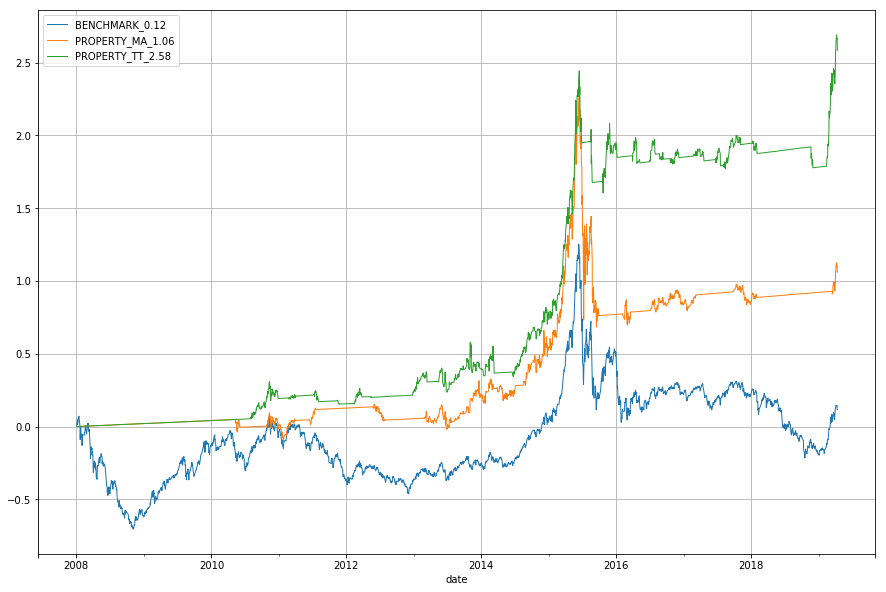

In [15]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# df = show_df.fillna(START_MONEY).copy()
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
# df['PROPERTY_ETF'] = stock_df_dict['163407']['open']
# stock_df_dict['163407']
# df
df.columns
# df.index
# df
df = df.dropna(how='any', inplace=False)

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
# for col in sorted(df.columns):
#     if 'PROPERTY' in col:
#         df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
#         ax = df.plot(kind='line', y=col, secondary_y=False, label='MA_%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# display_charts(df, kind='line', figsize=(900, 600), logy=False)

In [16]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
# df.drop(columns=['PROPERTY_TT'], inplace=True)
df.columns

show_columns = ['close']
df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        show_columns.append(col)
#     if 'CASH' in col:
#         df[col] = df[col] / df.iloc[0][col]
#         show_columns.append(col)
        
# df['unused'] = df['CASH'] / df['PROPERTY_TT']
# df = df.loc['20070101':]
# show_columns = ['unused']
# show_columns.append('unused')

df = df.loc[:, show_columns]
df.reset_index(drop=False, inplace=True)
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index(keys=['date'], inplace=True)

# display_charts(df, chart_type='stock', figsize=(900, 600), logy=False)

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_30_MAX',
       'ROLLING_20_MIN', 'MA90', 'MA120', 'CASH', 'PROPERTY_TT',
       'PROPERTY_MA'],
      dtype='object')